In [1]:
import sys
sys.path.insert(0,'/workspace/WorldPeatland/code/')
from gdal_sheep import *

import rasterio
import xarray as xr
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
path = f'/wp_data/sites/Degero/MODIS/analytics/*pct_data_available.tif'
glob(path)

['/wp_data/sites/Degero/MODIS/analytics/_LST_Day_1km_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_Fpar_500m_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_1_km_16_days_EVI_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_LST_Night_1km_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_ET_500m_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_Albedo_WSA_Band2_pct_data_available.tif',
 '/wp_data/sites/Degero/MODIS/analytics/_Lai_500m_pct_data_available.tif']

### Set test site

In [3]:
site = 'Norfolk'

In [4]:
### Choose the product

In [5]:
product_list = ['Lai_500m','Albedo_WSA_Band2','ET_500m','EVI','Fpar_500m','LST_Night_1km', 'LST_Day_1km']

In [6]:
product = product_list[3]

In [7]:
# these are the QA analytics calculated
path = f'/wp_data/sites/{site}/MODIS/analytics/*{product}*pct_data_available.tif'
l = glob(path)
l

['/wp_data/sites/Norfolk/MODIS/analytics/_1_km_16_days_EVI_pct_data_available.tif']

### % data available 

In [8]:
tiff_file = l[0]
tiff_file

'/wp_data/sites/Norfolk/MODIS/analytics/_1_km_16_days_EVI_pct_data_available.tif'

In [9]:
# Open the TIFF file using rasterio
with rasterio.open(tiff_file) as src:
    # Read the data
    data = src.read()

    transform = src.transform
    height, width = src.height, src.width # height = lat,y ; width = lon,x

    x = np.arange(width) * transform[0] + transform[2]
    y = np.arange(height) * transform[4] + transform[5]
    y = y[::-1]  # Reverse y for correct orientation

    coords = {
        "y": y,
        "x": x
    }
    attrs = src.meta.copy()

    data_vars = {f'pct_data_available': (("y", "x"), data[i]) for i in range(data.shape[0])}
    ds_pct = xr.Dataset(data_vars, coords=coords, attrs=attrs)
    
bd_pct = ds_pct['pct_data_available']

In [16]:
bd_pct

<xarray.DataArray 'pct_data_available' (y: 1, x: 2)>
array([[67.24137931, 69.39655172]])
Coordinates:
  * y        (y) float64 5.842e+06
  * x        (x) float64 3.086e+04 3.168e+04

### max gap length

In [10]:
path = f'/wp_data/sites/{site}/MODIS/analytics/*{product}*_max_gap_length.tif'
l = glob(path)
l

['/wp_data/sites/Norfolk/MODIS/analytics/_1_km_16_days_EVI_max_gap_length.tif']

In [11]:
# max gap length
tiff_file = l[0]


# Open the TIFF file using rasterio
with rasterio.open(tiff_file) as src:
    # Read the data
    data = src.read()

    transform = src.transform
    height, width = src.height, src.width # height = lat,y ; width = lon,x

    x = np.arange(width) * transform[0] + transform[2]
    y = np.arange(height) * transform[4] + transform[5]
    y = y[::-1]  # Reverse y for correct orientation

    coords = {
        "y": y,
        "x": x
    }
    attrs = src.meta.copy()

    data_vars = {f'max_gap_length': (("y", "x"), data[i]) for i in range(data.shape[0])}
    ds_max = xr.Dataset(data_vars, coords=coords, attrs=attrs)


bd_max = ds_max['max_gap_length']

### Plot

In [12]:
# plot settings:

cmap = 'viridis'
dpi = 250

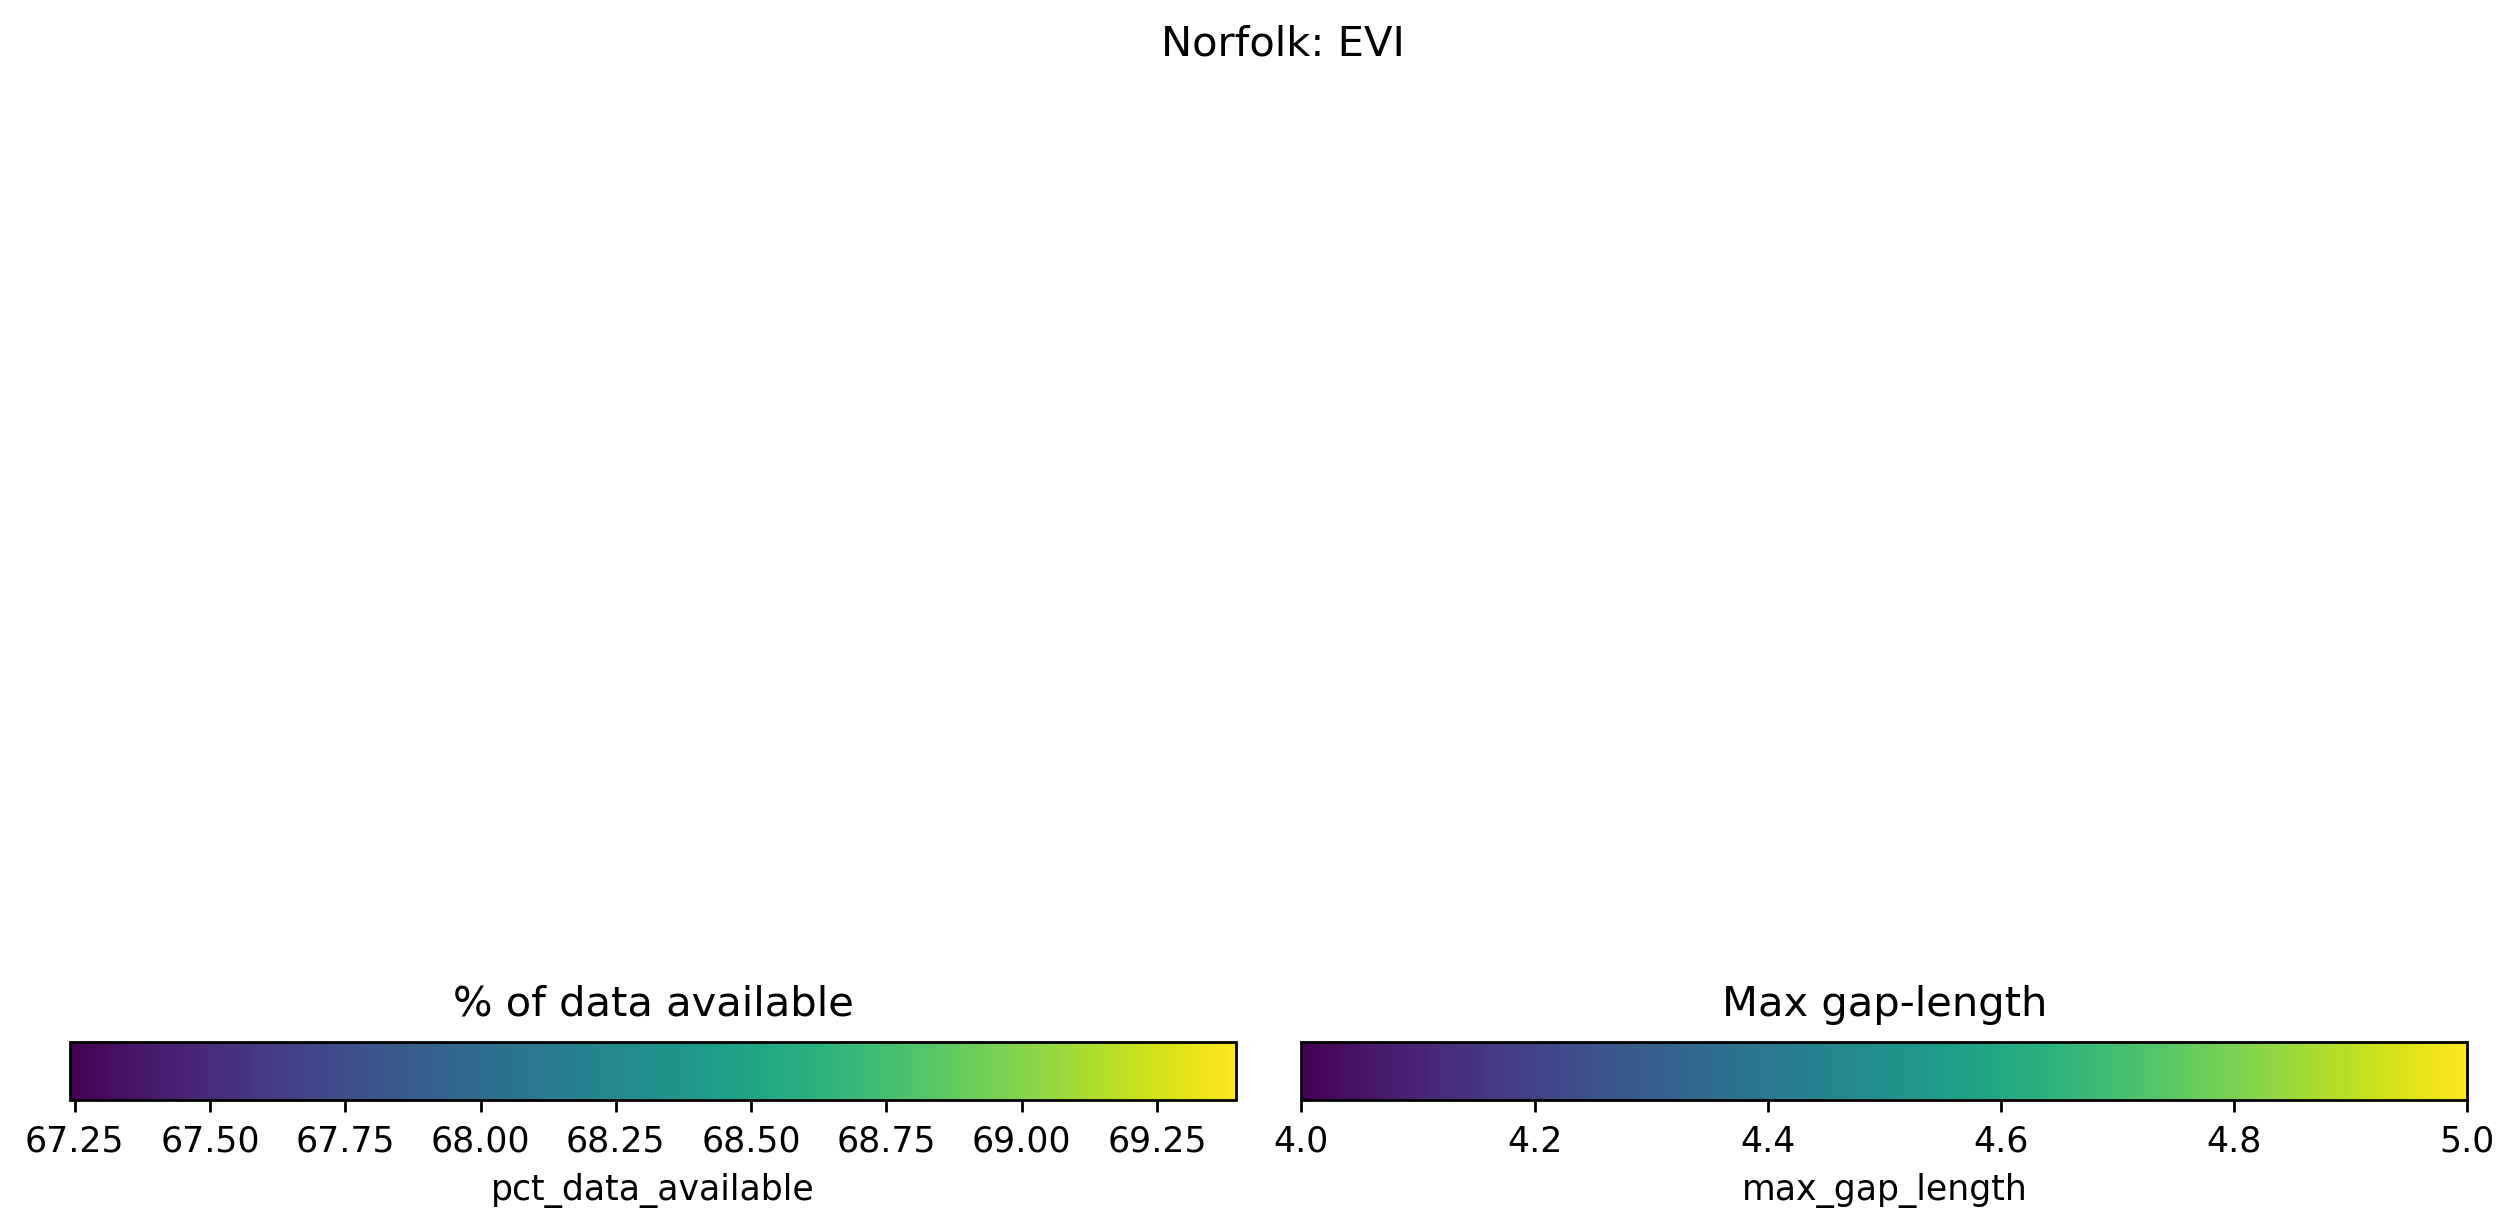

In [15]:
'''

Similar to the TATSSI UI QA visualization 

https://github.com/GerardoLopez/TATSSI/blob/122074a1e3015e8ade99dfb08d5a3b712b276bda/TATSSI/UI/plots_qa_analytics.py#L498

'''

globe=ccrs.Globe(ellipse=None, 
                 semimajor_axis=6371007.181, 
                 semiminor_axis=6371007.181)

proj = ccrs.Sinusoidal(globe=globe)


fig, (ax, bx) = plt.subplots(1, 2, figsize=(10,5),
                #sharex=True, sharey=True, tight_layout=True, dpi=dpi,
                sharex=True, sharey=True, dpi=dpi,
                subplot_kw=dict(projection=proj))

for _axis in [ax, bx]:
    _axis.coastlines(resolution='10m', color='white')
    _axis.add_feature(cfeature.BORDERS, edgecolor='white')
    _axis.gridlines()

    
# plot % data available
bd_pct.plot.imshow(
    ax=ax, cmap=cmap,
    cbar_kwargs={'orientation':'horizontal',
                 'pad' : 0.005},
transform=proj
)
ax.set_frame_on(False)
ax.axis('off')
ax.set_aspect('equal')
ax.title.set_text('% of data available')


# plot max gap length
bd_max.plot.imshow(
        ax=bx, cmap=cmap,
        cbar_kwargs={'orientation':'horizontal',
                     'pad' : 0.005},
        transform=proj
)

bx.set_frame_on(False)
bx.axis('off')
bx.set_aspect('equal')
bx.title.set_text('Max gap-length')

fig.suptitle(f'{site}: {product}')
fig.canvas.draw()
plt.tight_layout()

# fig.savefig(f'/workspace/WorldPeatland/visualisation/{site}_{product}_QA_analytics.png', dpi=fig.dpi)